In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import spotpy
from scipy import stats

import cartopy.feature as cfeature
import numpy as np
import cartopy.crs as ccrs
import cartopy
import colorcet as cc
from cmcrameri import cm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import proplot as pplt
import xarray 
from matplotlib import rc,rcParams

#warning
import warnings
warnings.filterwarnings('ignore')

dir_in = 'D:/Xanthos-Repo/Data for Figures-Xanthos WM'

In [2]:
basinName = pd.read_csv(dir_in + '/BasinNames235.txt')
basin_id = pd.read_csv(dir_in + '/basin.csv')

GRDC_xanthosCoordIndx = pd.read_csv(dir_in + '/GRDC_stations_list.csv')
n_nbasins = GRDC_xanthosCoordIndx.shape[0] 
basins91 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)

# parameters and climate data
parameters_optimalset = np.load(dir_in + '/parameters_optimalset_02282022.npy')
tasmin = np.load(dir_in + '/tasmin_watch_monthly_degc_1971_2001.npy')
prcp = np.load(dir_in + '/pr_gpcc_watch_monthly_mmpermth_1971_2001.npy')
snow = np.load(dir_in + '/snow_watch_monthly_degc_1971_2001.npy')

# Basin level

In [3]:
# get grid indices for the current basin
dir_usgrid = dir_in + '/UScells/contributing_grids_all'

SNmonthly = np.zeros([n_nbasins,372])
Pmonthly  = np.zeros([n_nbasins,372])

for ii in range(n_nbasins):
    basin_num = basins91[ii]
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad) 
    
    #P
    Pmonthly[ii,:] = np.mean(prcp[basin_idx,:],0)
    #snow
    SNmonthly[ii,:] = np.mean(snow[basin_idx,:],0)

# basin P
basinPrcP = pd.DataFrame(Pmonthly.T)
basinPrcP.index = pd.date_range(start='01-01-1971', end='31-12-2001', freq='MS')
prcp_mm =  basinPrcP.groupby(basinPrcP.index.month).mean()
prcp_mean_annual = prcp_mm.sum(axis=0)


# Basin snow
basinSnow = pd.DataFrame(SNmonthly.T)
basinSnow.index = pd.date_range(start='01-01-1971', end='31-12-2001', freq='MS')
snow_mm =  basinSnow.groupby(basinSnow.index.month).mean()
snow_mean_annual = snow_mm.sum(axis=0)
snow_mean_annual
# Basin snowfrac
sn_fr = np.array(snow_mean_annual / prcp_mean_annual)

In [4]:
file_dir_watch_vald = dir_in + '/Simulated/SimulatedFinal-HP/flow/'
file_dir_watch_natr = dir_in + '/Simulated/SimulatedFinal-YL/flow/'
basin_235_xanthos = gpd.read_file(dir_in + '/basin_235_xanthos/basin_harmed.shp')
xx = np.zeros([n_nbasins,])
for ii in range(n_nbasins):
    basin_num = basins91[ii]    
    aa = np.where(parameters_optimalset[:,0] == basin_num)[0][0]
    snowFrac = sn_fr[ii]


    #################
    indx_poly = np.where(basin_235_xanthos['GRIDCODE']==basin_num)[0]
    basin_235_xanthos.loc[indx_poly,'a'] = parameters_optimalset[aa,1]
    basin_235_xanthos.loc[indx_poly,'b'] = parameters_optimalset[aa,2]
    basin_235_xanthos.loc[indx_poly,'c'] = parameters_optimalset[aa,3]
    basin_235_xanthos.loc[indx_poly,'d'] = parameters_optimalset[aa,4]    
    if snowFrac > 0.05:
        basin_235_xanthos.loc[indx_poly,'m'] = parameters_optimalset[aa,5]        
    else:
        basin_235_xanthos.loc[indx_poly,'m'] = 0
    basin_235_xanthos.loc[indx_poly,'beta'] = parameters_optimalset[aa,6]        

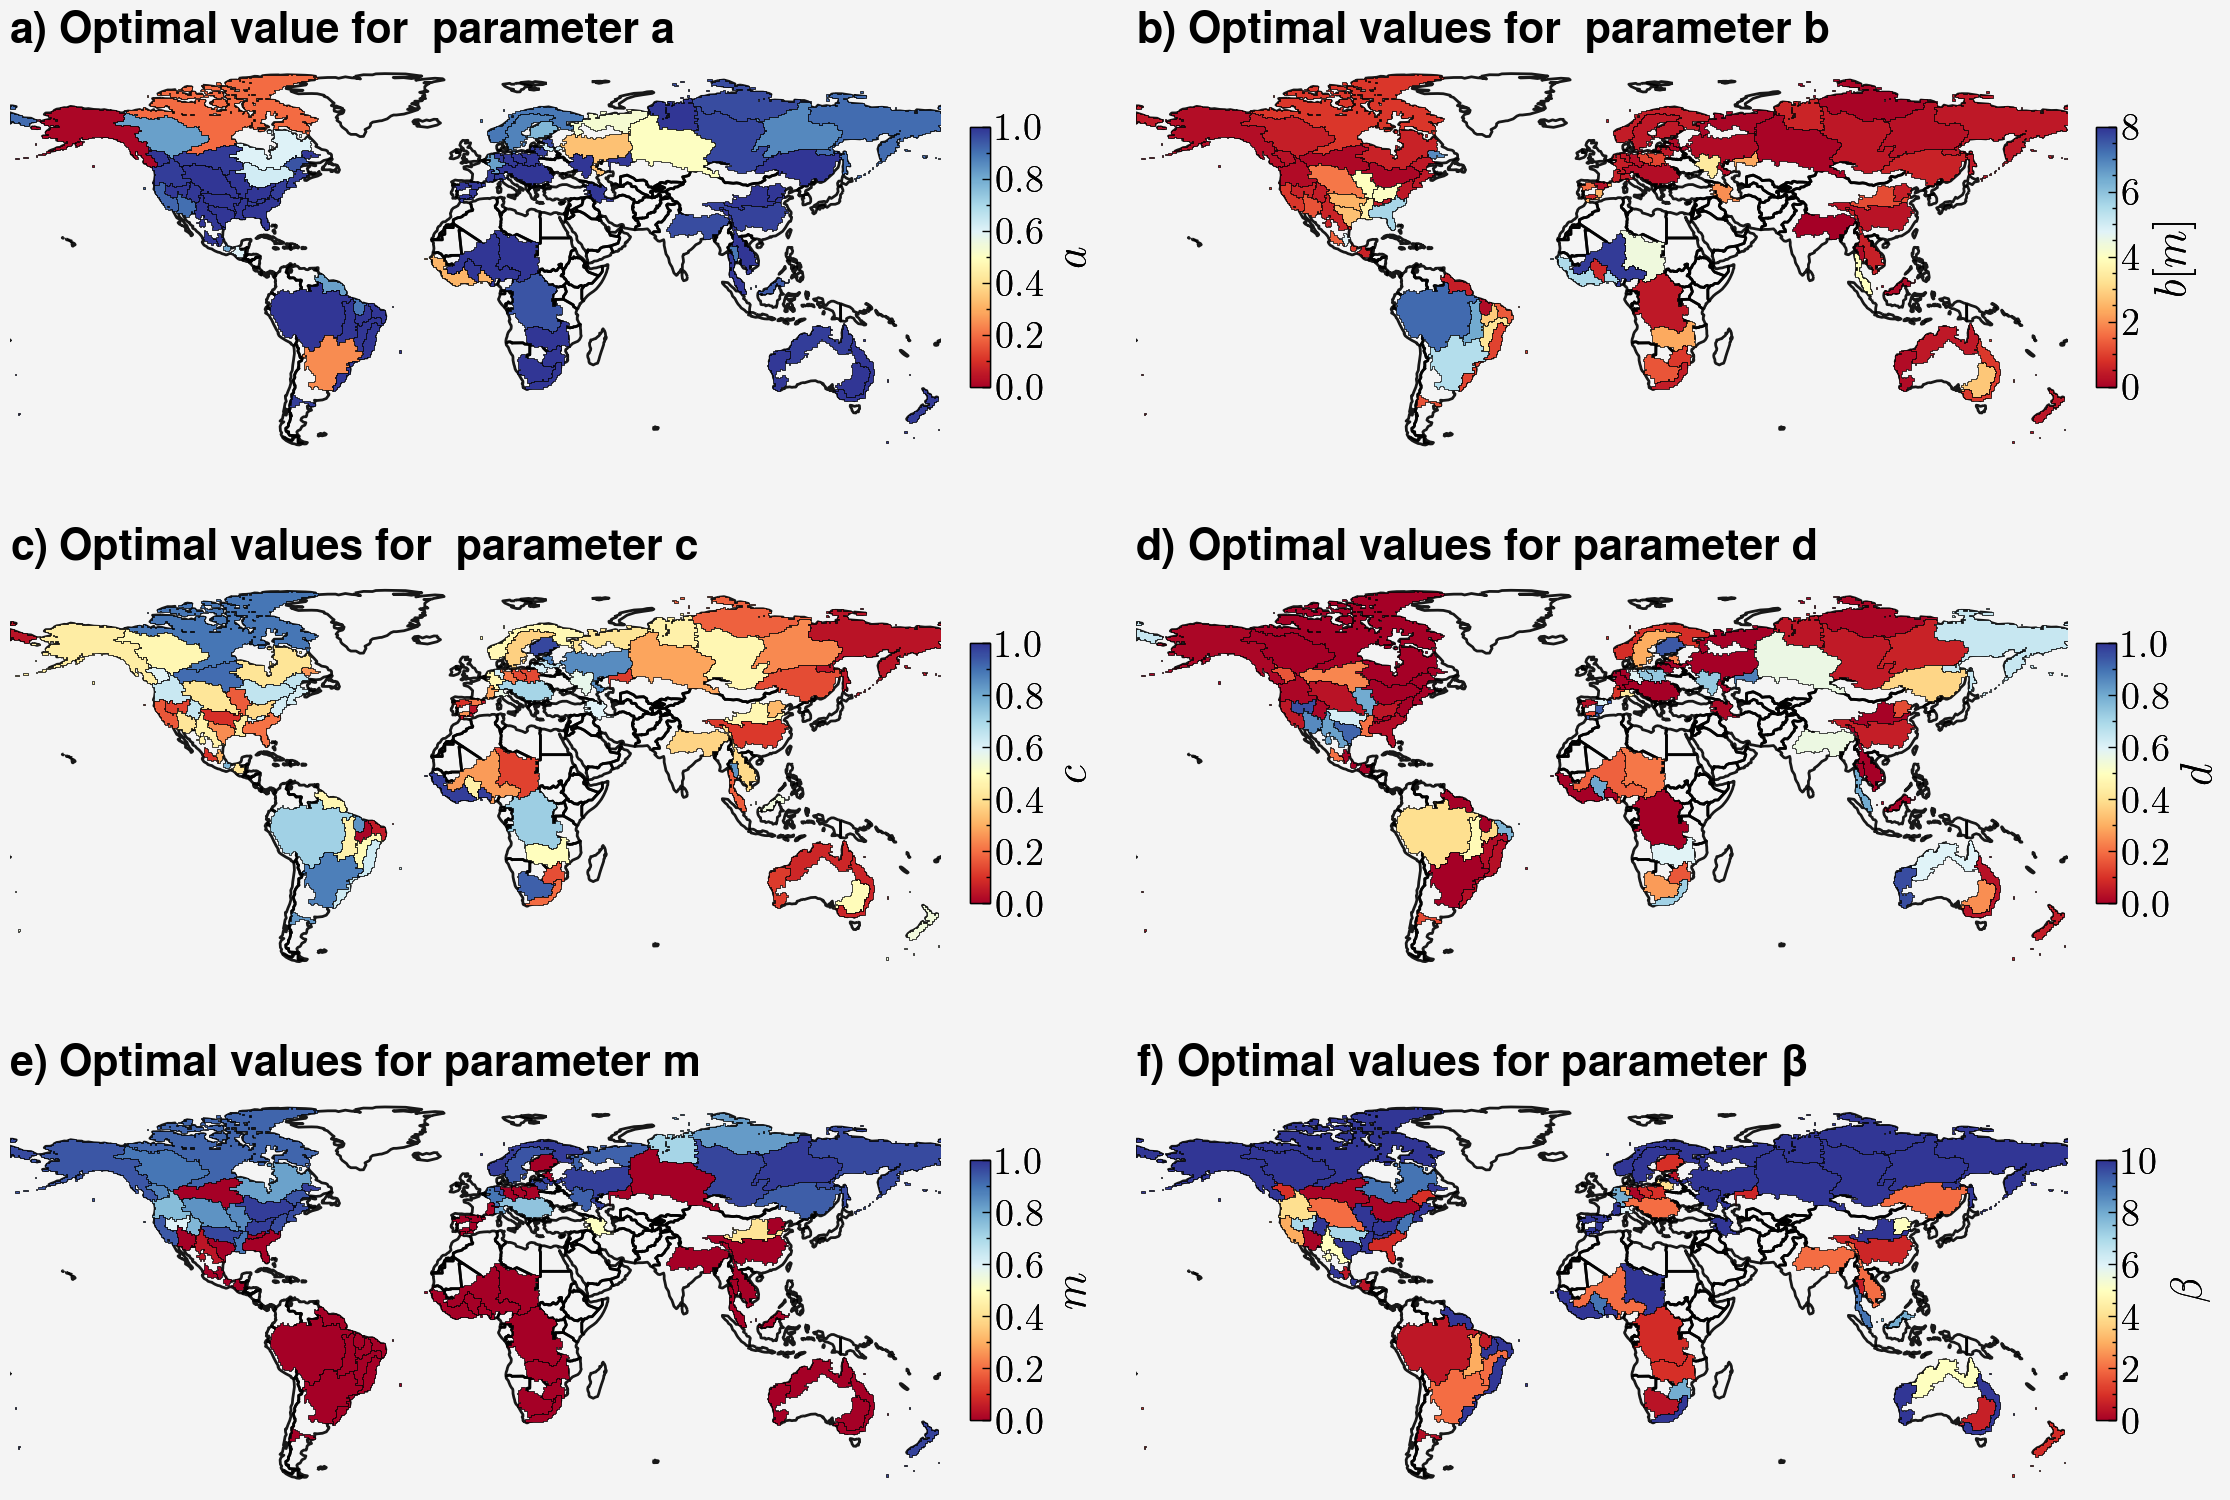

In [5]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 14, 'font.weight':'bold'}) 
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'


SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
BASE_PLOT = {"facecolor": 'none', "edgecolor": 'k', "alpha": 0.9,}#  "figsize": (4, 4)}


CRS = "EPSG:4326"
## Ploting
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
BASE_PLOT = {"facecolor": 'none', "edgecolor": 'k', "alpha": 0.9,"linewidth":1}

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
global_shape = gpd.GeoDataFrame(geometry=world.geometry, crs=world.crs)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


N=10
c = np.linspace(-N / 2, N / 2, N + 1)
fig, axes = pplt.subplots(nrows=3, ncols=2, share=0, space = 3.0, refheight='2.0')
plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):
        # a
        ax = axes[0]
        #global_shape.to_crs(CRS).plot(ax=ax,**BASE_PLOT) 
        world.to_crs(CRS).plot(ax=ax,**BASE_PLOT)    
        basin_235_xanthos.to_crs(CRS).plot(ax=ax, column='a',  cmap='RdYlBu', legend=True, edgecolor='k',linewidth=0.25, vmin=0, vmax=1.0,
                                        legend_kwds={'label': r'$a$', 'shrink':0.65,'width':0.10,
                                                     'ticks':0.2, 'minorticks':0.1, 'labelweight':'bold', 'labelsize':16})                                                                                  
        ax.axis(False)
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.autoscale(tight=True)  
        ax.set_ylim([-60,90]) 
        ax.format(title= 'Optimal value for  parameter a', titleweight = 'bold', titleloc='l',abcstyle='a)', fontsize=12)  

        # b   
        ax = axes[1]
        #global_shape.to_crs(CRS).plot(ax=ax,**BASE_PLOT)    
        world.to_crs(CRS).plot(ax=ax,**BASE_PLOT)    
        basin_235_xanthos.to_crs(CRS).plot(ax=ax, column='b',  cmap='RdYlBu', legend=True, edgecolor='k',linewidth=0.25, vmin=0, vmax=8.0,
                                        legend_kwds={'label': r'$b[m]$', 'shrink':0.65,'width':0.10,
                                                     'ticks':2, 'minorticks':0.5, 'labelweight':'bold', 'labelsize':16})                                                                                  
        ax.axis(False)
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.autoscale(tight=True)  
        ax.set_ylim([-60,90]) 
        ax.format(title= 'Optimal values for  parameter b', titleweight = 'bold', titleloc='l',abcstyle='a)', fontsize=12) 
          

        # c   
        ax = axes[2]
        world.to_crs(CRS).plot(ax=ax,**BASE_PLOT)    
        basin_235_xanthos.to_crs(CRS).plot(ax=ax, column='c',  cmap='RdYlBu', legend=True, edgecolor='k',linewidth=0.25, vmin=0, vmax=1.0,
                                        legend_kwds={'label': r'$c$', 'shrink':0.65,'width':0.10,
                                                     'ticks':0.2, 'minorticks':0.1, 'labelweight':'bold', 'labelsize':16})                                                                                  
        ax.axis(False)
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.autoscale(tight=True)  
        ax.set_ylim([-60,90]) 
        ax.format(title= 'Optimal values for  parameter c', titleweight = 'bold', titleloc='l',abcstyle='a)', fontsize=12) 


        # a
        ax = axes[3]
        #global_shape.to_crs(CRS).plot(ax=ax,**BASE_PLOT) 
        world.to_crs(CRS).plot(ax=ax,**BASE_PLOT)    
        basin_235_xanthos.to_crs(CRS).plot(ax=ax, column='d',  cmap='RdYlBu', legend=True, edgecolor='k',linewidth=0.25, vmin=0, vmax=1.0,
                                        legend_kwds={'label': r'$d$', 'shrink':0.65,'width':0.10,
                                                     'ticks':0.2, 'minorticks':0.1, 'labelweight':'bold', 'labelsize':16})                                                                                  
        ax.axis(False)
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.autoscale(tight=True)  
        ax.set_ylim([-60,90]) 
        ax.format(title= 'Optimal values for parameter d', titleweight = 'bold',titleloc='l',abcstyle='a)', fontsize=12) 

        # b   
        ax = axes[4]
        world.to_crs(CRS).plot(ax=ax,**BASE_PLOT)    
        basin_235_xanthos.to_crs(CRS).plot(ax=ax, column='m',  cmap='RdYlBu', legend=True, edgecolor='k',linewidth=0.25, vmin=0, vmax=1.0,
                                        legend_kwds={'label': r'$m$', 'shrink':0.65,'width':0.10,
                                                     'ticks':0.2, 'minorticks':0.1, 'labelweight':'bold', 'labelsize':16})                                                                                  
        ax.axis(False)
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.autoscale(tight=True)  
        ax.set_ylim([-60,90]) 
        ax.format(title= 'Optimal values for parameter m', titleweight = 'bold',titleloc='l',abcstyle='a)', fontsize=12) 
          

        # c   
        ax = axes[5]
        world.to_crs(CRS).plot(ax=ax,**BASE_PLOT)    
        basin_235_xanthos.to_crs(CRS).plot(ax=ax, column='beta',  cmap='RdYlBu', legend=True, edgecolor='k',linewidth=0.25, vmin=0, vmax=10.0,
                                        legend_kwds={'label': r'$\beta$', 'shrink':0.65,'width':0.10,
                                                     'ticks':2, 'minorticks':0.5, 'labelweight':'bold', 'labelsize':16})                                                                                  
        ax.axis(False)
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.autoscale(tight=True)  
        ax.set_ylim([-60,90]) 
        ax.format(title= 'Optimal values for parameter ' + r'$\beta$', titleweight = 'bold', titleloc='l',abcstyle='a)', fontsize=12) 

plt.tight_layout()

#dir_out = 'D:\\Xanthos-Repo\\figures\\'
#plt.savefig(dir_out + "Figure-7.png", **SAVE_KWDS)   